In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
data_df = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
seq_df = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

In [3]:
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
data_df.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [5]:
codone_to_vec = {}

with open('protVec_100d_3grams.csv', 'r') as file:
    for line in file.readlines():
        tokens = line[1:-2].split('\t')
        codone_to_vec[tokens[0]] = np.array(tokens[1:], dtype=np.float32)

codone_to_vec['AAA'].shape, codone_to_vec['AAA']
codone_to_vec['000'] = np.zeros(100, dtype=np.float32)
codone_to_id = {}
embedding = []
for cod, vec in codone_to_vec.items():
    codone_to_id[cod] = len(embedding)
    embedding.append(vec)
embedding = np.array(embedding, dtype=np.float32)

Для ускорения обучения рассматриваю только 100 популярных классов

In [6]:
MAX_LEN = seq_df['Sequences'].str.len().max() // 3
EMBED_SIZE = 100
CLASS_COUNT = 100
BATCH_SIZE = 48
TEST_RATIO = 0.2

In [7]:
families = data_df['FamilyID']
family_to_id = {c: i for i, (c, _) in enumerate(Counter(families).most_common(CLASS_COUNT))}

In [8]:
np.random.seed(123)

def seq_to_ids(seq):
    result = np.zeros(MAX_LEN, dtype=np.int32)
    
    for j in range(len(seq) // 3):
        codone = seq[3 * j: 3 * j + 3]
        result[j] = codone_to_id[codone] if codone in codone_to_id else codone_to_id['<unk>'] 
    for j in range(len(seq) // 3, MAX_LEN):
        result[j] = codone_to_id['000']
    
    return result

seqs_and_families = []
for i in range(len(seq_df)):
    seq = seq_df.iloc[i, :][0]
    family = data_df.iloc[i].FamilyID
    if family in family_to_id:
        seqs_and_families.append((seq_to_ids(seq), family_to_id[family]))

In [9]:
def gen_sample(data):
    i = np.random.randint(len(data))
    return data[i]

def gen_batch(data):
    while True:
        x, y = zip(*[gen_sample(data) for i in range(BATCH_SIZE)])
        yield np.array(x), np.array(y)

In [10]:
from lazy import lazy

class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
        # self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.embedding = tf.constant(embedding)
            self.seq_data = tf.placeholder(tf.int32, [None, self.params.seq_length])
            self.data = tf.nn.embedding_lookup(self.embedding, self.seq_data)
            #tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.int32, [None])
            self.vec_target = tf.one_hot(self.target, CLASS_COUNT)
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('error', self.error)
            self.summary = tf.summary.merge_all()
            self.saver = tf.train.Saver()
            
    @lazy
    def length(self):
    # First, we obtain the lengths of sequences in the current data batch. We need this since
    # the data comes as a single tensor, padded with zero vectors to the longest review length.
    # Instead of keeping track of the sequence lengths of every review, we just compute it
    # dynamically in TensorFlow.
    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
    # Note that the last relevant output activation of the RNN has a different index for each
    # sequence in the training batch. This is because each review has a different length. We
    # already know the length of each sequence.
    # The problem is that we want to index in the dimension of time steps, which is
    # the second dimension in the batch of shape  (sequences, time_steps, word_vectors) .
    
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.vec_target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.vec_target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.vec_target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # RNNs are quite hard to train and weights tend to diverge if the hyper parameters do not
    # play nicely together. The idea of gradient clipping is to restrict the the values of the
    # gradient to a sensible range. This way, we can limit the maximum weight updates.

        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            # As of now, TensorFlow only supports indexing along the first dimension, using
            # tf.gather() . We thus flatten the first two dimensions of the output activations from their
            # shape of  sequences x time_steps x word_vectors  and construct an index into this resulting tensor.
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            # The index takes into account the start indices for each sequence in the flat tensor and adds
            # the sequence length to it. Actually, we only add  length - 1  so that we select the last valid
            # time step.
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [11]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=100,
    optimizer=tf.train.RMSPropOptimizer(0.005),
    batch_size=BATCH_SIZE,
    gradient_clipping=100,
    seq_length=MAX_LEN,
    embed_length=EMBED_SIZE,
    classes=CLASS_COUNT,
    device='gpu',
    mem_frac=1.0,
    max_iter=None,
    test_size=TEST_RATIO
)
params

AttrDict({'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>, 'rnn_hidden': 100, 'optimizer': <tensorflow.python.training.rmsprop.RMSPropOptimizer object at 0x7fb090e81240>, 'batch_size': 48, 'gradient_clipping': 100, 'seq_length': 7384, 'embed_length': 100, 'classes': 100, 'device': 'gpu', 'mem_frac': 1.0, 'max_iter': None, 'test_size': 0.2})

In [18]:
np.random.shuffle(seqs_and_families)
train_data = seqs_and_families[:int(len(seqs_and_families) * (1 - TEST_RATIO))]
test_data = seqs_and_families[int(len(seqs_and_families) * (1 - TEST_RATIO)):]
batch_gen = gen_batch(train_data)
print(len(train_data), len(test_data))
tf.reset_default_graph()

model = SequenceClassificationModel(params)

76415 19104


/home/tehnar/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    cur_iter = 1
    sum_error = 0
    sum_loss = 0
    for batch in batch_gen:
        feed = {model.seq_data: batch[0], model.target: batch[1]}
        error, loss, _, summary_str = sess.run([model.error, model.cost, model.optimize, model.summary], feed)
        sum_error += error
        sum_loss += loss
        if cur_iter % 25 == 0:
            print('{}: avg error {:3.1f}%, avg loss {:3.3f}'.format(cur_iter, 100 * sum_error / 25, sum_loss / 25))
            sum_error = 0
            sum_loss = 0
            summary_writer.add_summary(summary_str, cur_iter)
            model.saver.save(sess,
                             save_path='checkpoints',
                             global_step=cur_iter)
        if cur_iter == 1300:
            break
        cur_iter += 1


In [14]:
with tf.Session() as sess:
    try:
        print("Trying to restore last checkpoint...")
        last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=".")
        model.saver.restore(sess, save_path=last_chk_path)
        print("Restored checkpoint from:", last_chk_path)
    except Exception as e:
        print(e)
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())

    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    cur_iter = 1
    sum_error = 0
    sum_loss = 0
    for i in range(0, len(test_data), BATCH_SIZE):
        x = []
        y = []
        batch_size = min(i + BATCH_SIZE, len(test_data)) - i
        for j in range(i, i + batch_size):
            x.append(test_data[j][0])
            y.append(test_data[j][1])
        feed = {model.seq_data: np.array(x), model.target: np.array(y)}
        error, loss = sess.run([model.error, model.cost], feed)
        sum_error += error * batch_size
        sum_loss += loss * batch_size
        if cur_iter % 25 == 0:
            print('Test error: {:3.3f}, test loss{:3.3f}'.format(100 * sum_error / cur_iter / BATCH_SIZE, sum_loss / cur_iter / BATCH_SIZE))
            
        cur_iter += 1
    print('Test error: {:3.3f}, test loss:{:3.3f}'.format(100 * sum_error / len(test_data), sum_loss / len(test_data)))


Trying to restore last checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoints-1000
Restored checkpoint from: ./checkpoints-1000
Test error: 26.833, test loss51.515
Test error: 28.208, test loss52.813
Test error: 28.222, test loss53.811
Test error: 28.063, test loss52.592
Test error: 27.817, test loss52.561
Test error: 27.583, test loss52.285
Test error: 27.655, test loss52.715
Test error: 27.979, test loss52.886
Test error: 27.824, test loss52.713
Test error: 27.967, test loss52.848
Test error: 27.841, test loss52.762
Test error: 27.757, test loss52.497
Test error: 28.006, test loss52.952
Test error: 27.940, test loss52.879
Test error: 27.950, test loss52.919
Test error: 27.895, test loss:52.841


### Random forest
К сожалению, после embedding весь датасет в память не влезает, поэтому обучаюсь только на 20% данных

In [25]:
from sklearn.ensemble import RandomForestClassifier

def get_x_y(data):
    x_data = []
    y_data = []
    for x, y in train_data:
        vec = np.zeros(MAX_LEN, dtype=np.float32)
        vec[:len(x)] = x
        x_data.append(vec)
        y_data.append(y)
    return np.array(x_data), np.array(y_data)

x_train, y_train = get_x_y(train_data[:len(train_data) // 5])
x_test, y_test = get_x_y(train_data[:len(test_data)])

model = RandomForestClassifier()
model.fit(x_data, y_data)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
'Acc: {}'.format((model.predict(x_test) == y_test).sum() / len(x_test))


'Acc: 0.5717332984361709'

### TSNE

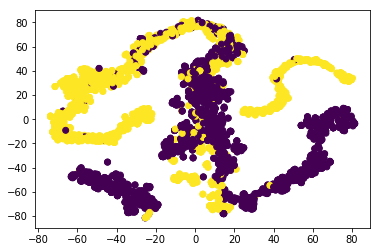

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
inds = ((y_train == 0) | (y_train == 1)).squeeze()
emb_x, emb_y = tsne.fit_transform(x_train[inds]), y_train[inds]
plt.scatter(emb_x[:, 0], emb_x[:, 1], c=emb_y)
plt.show()